In [1]:
# Cell 1: Importing Required Libraries

import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import time
import warnings
warnings.filterwarnings('ignore')

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Adding src directory to path
sys.path.append('../src')

# Importing custom utilities
from config import *
from data_utils import retrieve_processed_datasets, load_resampled_data
from pytorch_models import (
    BatchNormClassifier,
    WeightedLossClassifier,
    calculate_pos_weight,
    prepare_data_loaders,
    train_pytorch_model,
    evaluate_pytorch_model,
    save_pytorch_model,
    load_pytorch_model
)
from evaluation_utils import (
    calculate_all_metrics,
    create_confusion_matrix,
    plot_roc_curve,
    plot_precision_recall_curve
)

# Setting visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("Set2")

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)

# Setting PyTorch random seed for reproducibility
torch.manual_seed(SEED_VALUE)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED_VALUE)

print("All libraries imported successfully!")
print(f"Working Directory: {Path.cwd()}")
print(f"Random Seed: {SEED_VALUE}")
print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA Device: {torch.cuda.get_device_name(0)}")

All libraries imported successfully!
Working Directory: C:\Users\Ashutosh\Documents\Projects\beyond-smote-evaluation\notebooks
Random Seed: 42
PyTorch Version: 2.6.0+cu124
CUDA Available: True
CUDA Device: NVIDIA GeForce RTX 3050 Ti Laptop GPU


In [2]:
# Cell 2: Loading Data and Create Train-Validation Split
# Loading processed data and creating validation split for PyTorch
# PyTorch needs separate validation set for early stopping

print("="*70)
print("LOADING DATA FOR PYTORCH")
print("="*70)

# Loading original processed datasets
X_train_full, X_test, y_train_full, y_test = retrieve_processed_datasets(
    file_prefix='higgs'
)

print("\nData loaded successfully!")
print(f"Training set: {X_train_full.shape}")
print(f"Test set: {X_test.shape}")

# Creating train-validation split from training data
# Using 80-20 split for train-val
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full,
    test_size=0.2,
    random_state=SEED_VALUE,
    stratify=y_train_full
)

print("\nTrain-Validation Split:")
print(f"  Training: {X_train.shape[0]:,} samples")
print(f"  Validation: {X_val.shape[0]:,} samples")
print(f"  Test: {X_test.shape[0]:,} samples")

# Displaying class distribution
print("\nClass Distribution:")
print(f"  Training - Signal: {y_train.sum():,} ({(y_train.sum()/len(y_train))*100:.2f}%)")
print(f"  Validation - Signal: {y_val.sum():,} ({(y_val.sum()/len(y_val))*100:.2f}%)")
print(f"  Test - Signal: {y_test.sum():,} ({(y_test.sum()/len(y_test))*100:.2f}%)")

LOADING DATA FOR PYTORCH
Loading processed data from C:\Users\Ashutosh\Documents\Projects\beyond-smote-evaluation\data\processed...
Datasets loaded successfully
Training shape: (800000, 28)
Testing shape: (200000, 28)

Data loaded successfully!
Training set: (800000, 28)
Test set: (200000, 28)

Train-Validation Split:
  Training: 640,000 samples
  Validation: 160,000 samples
  Test: 200,000 samples

Class Distribution:
  Training - Signal: 338,990 (52.97%)
  Validation - Signal: 84,748 (52.97%)
  Test - Signal: 105,935 (52.97%)


In [3]:
# Cell 3: Calculating Class Weights for Weighted Loss
# Computing positive class weight for imbalanced learning
# Method: weight = n_negative / n_positive

print("="*70)
print("CALCULATING CLASS WEIGHTS")
print("="*70)

# Calculating positive weight
pos_weight = calculate_pos_weight(y_train.values)

print(f"\nClass Weight Calculation:")
print(f"  Negative Class Count: {(y_train == 0).sum():,}")
print(f"  Positive Class Count: {(y_train == 1).sum():,}")
print(f"  Positive Weight: {pos_weight.item():.4f}")

print("\nInterpretation:")
print(f"  Loss for minority class samples will be weighted {pos_weight.item():.2f}x higher")
print(f"  This compensates for class imbalance without data resampling")

CALCULATING CLASS WEIGHTS

Class Weight Calculation:
  Negative Class Count: 301,010
  Positive Class Count: 338,990
  Positive Weight: 0.8880

Interpretation:
  Loss for minority class samples will be weighted 0.89x higher
  This compensates for class imbalance without data resampling


In [4]:
# Cell 4: Initializing PyTorch Models
# Creating instances of both PyTorch model architectures
# Models: BatchNormClassifier, WeightedLossClassifier

print("="*70)
print("INITIALIZING PYTORCH MODELS")
print("="*70)

# Getting input dimension
input_dim = X_train.shape[1]

# Initializing BatchNormClassifier (for use with resampled data)
model_batchnorm = BatchNormClassifier(
    input_dim=input_dim,
    hidden_dims=DL_CONFIG['architecture'],
    dropout_rates=DL_CONFIG['dropout_vals']
)

# Initializing WeightedLossClassifier (for use with weighted loss)
model_weighted = WeightedLossClassifier(
    input_dim=input_dim,
    hidden_dims=DL_CONFIG['architecture'],
    dropout_rates=DL_CONFIG['dropout_vals']
)

print("\nModel 1: BatchNormClassifier")
print(f"  Architecture: {input_dim} -> {' -> '.join(map(str, DL_CONFIG['architecture']))} -> 1")
print(f"  Total Parameters: {sum(p.numel() for p in model_batchnorm.parameters()):,}")
print(f"  Trainable Parameters: {sum(p.numel() for p in model_batchnorm.parameters() if p.requires_grad):,}")

print("\nModel 2: WeightedLossClassifier")
print(f"  Architecture: {input_dim} -> {' -> '.join(map(str, DL_CONFIG['architecture']))} -> 1")
print(f"  Total Parameters: {sum(p.numel() for p in model_weighted.parameters()):,}")

print("\nBoth models use:")
print(f"  - Batch Normalization after each layer")
print(f"  - ReLU activation")
print(f"  - Dropout: {DL_CONFIG['dropout_vals']}")
print(f"  - Sigmoid output")

INITIALIZING PYTORCH MODELS

Model 1: BatchNormClassifier
  Architecture: 28 -> 256 -> 128 -> 64 -> 32 -> 1
  Total Parameters: 51,649
  Trainable Parameters: 51,649

Model 2: WeightedLossClassifier
  Architecture: 28 -> 256 -> 128 -> 64 -> 32 -> 1
  Total Parameters: 51,649

Both models use:
  - Batch Normalization after each layer
  - ReLU activation
  - Dropout: [0.3, 0.3, 0.2]
  - Sigmoid output


In [6]:
# Cell 5: Experiment 1 - BatchNorm with Baseline (No Resampling)
# Establishing PyTorch baseline on original imbalanced data
# Lower performance is expected due to imbalance

print("="*70)
print("EXPERIMENT 1: BATCHNORM + BASELINE (No Resampling)")
print("="*70)

# Preparing data loaders for baseline
train_loader_baseline, val_loader_baseline = prepare_data_loaders(
    X_train=X_train.values,
    y_train=y_train.values,
    X_val=X_val.values,
    y_val=y_val.values,
    batch_size=DL_CONFIG['batch_count']
)

print(f"\nData loaders created:")
print(f"  Training batches: {len(train_loader_baseline)}")
print(f"  Validation batches: {len(val_loader_baseline)}")

# Training model
print(f"\nTraining BatchNormClassifier on baseline data...")
print(f"Epochs: {DL_CONFIG['epoch_count']}, Learning Rate: {DL_CONFIG['learn_rate']}")

model_baseline = BatchNormClassifier(input_dim=input_dim)

trained_baseline, history_baseline = train_pytorch_model(
    model=model_baseline,
    train_loader=train_loader_baseline,
    val_loader=val_loader_baseline,
    epochs=DL_CONFIG['epoch_count'],
    learning_rate=DL_CONFIG['learn_rate'],
    pos_weight=None,  # No weighting for baseline
    patience=DL_CONFIG['patience'],
    device=DL_CONFIG['compute_device'],
    verbose=True
)

# Evaluating on test set
print("\nEvaluating on test set...")
baseline_results = evaluate_pytorch_model(
    model=trained_baseline,
    X_test=X_test.values,
    y_test=y_test.values,
    batch_size=DL_CONFIG['batch_count'],
    device=DL_CONFIG['compute_device'],
    verbose=True
)

# Computing comprehensive metrics
baseline_metrics = calculate_all_metrics(
    y_true=y_test.values,
    y_pred=baseline_results['y_pred'],
    y_proba=baseline_results['y_proba']
)

print("\nBaseline PyTorch Performance:")
print(f"  Accuracy: {baseline_metrics['accuracy']:.4f}")
print(f"  Precision: {baseline_metrics['precision']:.4f}")
print(f"  Recall: {baseline_metrics['recall']:.4f}")
print(f"  F1-Score: {baseline_metrics['f1_score']:.4f}")
print(f"  AUC-ROC: {baseline_metrics['auc_roc']:.4f}")
print(f"  AUC-PR: {baseline_metrics['auc_pr']:.4f}")

# Storing results
pytorch_results = {
    'baseline_batchnorm': {
        'model': trained_baseline,
        'history': history_baseline,
        'metrics': baseline_metrics,
        'predictions': baseline_results
    }
}

EXPERIMENT 1: BATCHNORM + BASELINE (No Resampling)

Data loaders created:
  Training batches: 1250
  Validation batches: 313

Training BatchNormClassifier on baseline data...
Epochs: 50, Learning Rate: 0.001
Epoch [5/50] - Train Loss: 0.5334, Train Acc: 0.7279, Val Loss: 0.5188, Val Acc: 0.7376
Epoch [10/50] - Train Loss: 0.5219, Train Acc: 0.7359, Val Loss: 0.5069, Val Acc: 0.7455
Epoch [15/50] - Train Loss: 0.5178, Train Acc: 0.7392, Val Loss: 0.5043, Val Acc: 0.7483
Epoch [20/50] - Train Loss: 0.5143, Train Acc: 0.7411, Val Loss: 0.5011, Val Acc: 0.7498
Epoch [25/50] - Train Loss: 0.5123, Train Acc: 0.7431, Val Loss: 0.4988, Val Acc: 0.7516
Epoch [30/50] - Train Loss: 0.5107, Train Acc: 0.7434, Val Loss: 0.4985, Val Acc: 0.7530
Epoch [35/50] - Train Loss: 0.5095, Train Acc: 0.7443, Val Loss: 0.4970, Val Acc: 0.7526
Epoch [40/50] - Train Loss: 0.5087, Train Acc: 0.7450, Val Loss: 0.4957, Val Acc: 0.7532
Epoch [45/50] - Train Loss: 0.5073, Train Acc: 0.7459, Val Loss: 0.4954, Val Acc:

In [7]:
# Cell 6: Experiment 2 - BatchNorm with SMOTE
# Training on SMOTE resampled data

print("="*70)
print("EXPERIMENT 2: BATCHNORM + SMOTE")
print("="*70)

# Loading SMOTE resampled data
X_smote, y_smote = load_resampled_data(
    method_name='smote',
    data_dir=RESAMPLED_DIR
)

print(f"\nSMOTE dataset loaded: {len(X_smote):,} samples")

# Creating train-val split from SMOTE data
X_train_smote, X_val_smote, y_train_smote, y_val_smote = train_test_split(
    X_smote, y_smote,
    test_size=0.2,
    random_state=SEED_VALUE,
    stratify=y_smote
)

# Preparing data loaders
train_loader_smote, val_loader_smote = prepare_data_loaders(
    X_train=X_train_smote.values,
    y_train=y_train_smote.values,
    X_val=X_val_smote.values,
    y_val=y_val_smote.values,
    batch_size=DL_CONFIG['batch_count']
)

# Training model
print("\nTraining BatchNormClassifier on SMOTE data...")
model_smote = BatchNormClassifier(input_dim=input_dim)

trained_smote, history_smote = train_pytorch_model(
    model=model_smote,
    train_loader=train_loader_smote,
    val_loader=val_loader_smote,
    epochs=DL_CONFIG['epoch_count'],
    learning_rate=DL_CONFIG['learn_rate'],
    pos_weight=None,
    patience=DL_CONFIG['patience'],
    device=DL_CONFIG['compute_device'],
    verbose=True
)

# Evaluating
smote_results = evaluate_pytorch_model(
    model=trained_smote,
    X_test=X_test.values,
    y_test=y_test.values,
    batch_size=DL_CONFIG['batch_count'],
    device=DL_CONFIG['compute_device'],
    verbose=True
)

smote_metrics = calculate_all_metrics(
    y_true=y_test.values,
    y_pred=smote_results['y_pred'],
    y_proba=smote_results['y_proba']
)

print("\nSMOTE PyTorch Performance:")
print(f"  F1-Score: {smote_metrics['f1_score']:.4f}")
print(f"  AUC-ROC: {smote_metrics['auc_roc']:.4f}")
print(f"  Improvement over Baseline: +{smote_metrics['f1_score'] - baseline_metrics['f1_score']:.4f}")

# Storing results
pytorch_results['smote_batchnorm'] = {
    'model': trained_smote,
    'history': history_smote,
    'metrics': smote_metrics,
    'predictions': smote_results
}

EXPERIMENT 2: BATCHNORM + SMOTE
Loading resampled data: smote
  Loaded 847,476 samples
  Features shape: (847476, 28)

SMOTE dataset loaded: 847,476 samples

Training BatchNormClassifier on SMOTE data...
Epoch [5/50] - Train Loss: 0.5322, Train Acc: 0.7295, Val Loss: 0.5151, Val Acc: 0.7418
Epoch [10/50] - Train Loss: 0.5205, Train Acc: 0.7373, Val Loss: 0.5045, Val Acc: 0.7486
Epoch [15/50] - Train Loss: 0.5159, Train Acc: 0.7401, Val Loss: 0.5000, Val Acc: 0.7513
Epoch [20/50] - Train Loss: 0.5129, Train Acc: 0.7421, Val Loss: 0.4985, Val Acc: 0.7526
Epoch [25/50] - Train Loss: 0.5111, Train Acc: 0.7437, Val Loss: 0.4973, Val Acc: 0.7537
Epoch [30/50] - Train Loss: 0.5091, Train Acc: 0.7453, Val Loss: 0.4953, Val Acc: 0.7548
Epoch [35/50] - Train Loss: 0.5076, Train Acc: 0.7458, Val Loss: 0.4940, Val Acc: 0.7557
Epoch [40/50] - Train Loss: 0.5065, Train Acc: 0.7469, Val Loss: 0.4929, Val Acc: 0.7573
Epoch [45/50] - Train Loss: 0.5058, Train Acc: 0.7464, Val Loss: 0.4922, Val Acc: 0.7

In [8]:
# Cell 7: Experiment 3 - BatchNorm with Borderline-SMOTE
# Training on Borderline-SMOTE resampled data
# Focus on boundary samples may improve classification

print("="*70)
print("EXPERIMENT 3: BATCHNORM + BORDERLINE-SMOTE")
print("="*70)

# Loading Borderline-SMOTE data
X_bsmote, y_bsmote = load_resampled_data(
    method_name='borderline_smote',
    data_dir=RESAMPLED_DIR
)

print(f"\nBorderline-SMOTE dataset loaded: {len(X_bsmote):,} samples")

# Creating train-val split
X_train_bsmote, X_val_bsmote, y_train_bsmote, y_val_bsmote = train_test_split(
    X_bsmote, y_bsmote,
    test_size=0.2,
    random_state=SEED_VALUE,
    stratify=y_bsmote
)

# Preparing data loaders
train_loader_bsmote, val_loader_bsmote = prepare_data_loaders(
    X_train=X_train_bsmote.values,
    y_train=y_train_bsmote.values,
    X_val=X_val_bsmote.values,
    y_val=y_val_bsmote.values,
    batch_size=DL_CONFIG['batch_count']
)

# Training
print("\nTraining BatchNormClassifier on Borderline-SMOTE data...")
model_bsmote = BatchNormClassifier(input_dim=input_dim)

trained_bsmote, history_bsmote = train_pytorch_model(
    model=model_bsmote,
    train_loader=train_loader_bsmote,
    val_loader=val_loader_bsmote,
    epochs=DL_CONFIG['epoch_count'],
    learning_rate=DL_CONFIG['learn_rate'],
    pos_weight=None,
    patience=DL_CONFIG['patience'],
    device=DL_CONFIG['compute_device'],
    verbose=True
)

# Evaluating
bsmote_results = evaluate_pytorch_model(
    model=trained_bsmote,
    X_test=X_test.values,
    y_test=y_test.values,
    batch_size=DL_CONFIG['batch_count'],
    device=DL_CONFIG['compute_device'],
    verbose=True
)

bsmote_metrics = calculate_all_metrics(
    y_true=y_test.values,
    y_pred=bsmote_results['y_pred'],
    y_proba=bsmote_results['y_proba']
)

print("\nBorderline-SMOTE PyTorch Performance:")
print(f"  F1-Score: {bsmote_metrics['f1_score']:.4f}")
print(f"  Improvement over Baseline: +{bsmote_metrics['f1_score'] - baseline_metrics['f1_score']:.4f}")

# Storing results
pytorch_results['borderline_smote_batchnorm'] = {
    'model': trained_bsmote,
    'history': history_bsmote,
    'metrics': bsmote_metrics,
    'predictions': bsmote_results
}

EXPERIMENT 3: BATCHNORM + BORDERLINE-SMOTE
Loading resampled data: borderline_smote
  Loaded 847,476 samples
  Features shape: (847476, 28)

Borderline-SMOTE dataset loaded: 847,476 samples

Training BatchNormClassifier on Borderline-SMOTE data...
Epoch [5/50] - Train Loss: 0.5416, Train Acc: 0.7218, Val Loss: 0.5239, Val Acc: 0.7345
Epoch [10/50] - Train Loss: 0.5297, Train Acc: 0.7304, Val Loss: 0.5137, Val Acc: 0.7414
Epoch [15/50] - Train Loss: 0.5252, Train Acc: 0.7339, Val Loss: 0.5095, Val Acc: 0.7436
Epoch [20/50] - Train Loss: 0.5223, Train Acc: 0.7353, Val Loss: 0.5070, Val Acc: 0.7459
Epoch [25/50] - Train Loss: 0.5200, Train Acc: 0.7369, Val Loss: 0.5061, Val Acc: 0.7466
Epoch [30/50] - Train Loss: 0.5181, Train Acc: 0.7380, Val Loss: 0.5037, Val Acc: 0.7487
Epoch [35/50] - Train Loss: 0.5171, Train Acc: 0.7388, Val Loss: 0.5042, Val Acc: 0.7485
Epoch [40/50] - Train Loss: 0.5160, Train Acc: 0.7395, Val Loss: 0.5027, Val Acc: 0.7501
Epoch [45/50] - Train Loss: 0.5152, Train

In [9]:
# Cell 8: Experiment 4 - BatchNorm with ADASYN
# Purpose: Training on ADASYN resampled data

print("="*70)
print("EXPERIMENT 4: BATCHNORM + ADASYN")
print("="*70)

# Loading ADASYN data
X_adasyn, y_adasyn = load_resampled_data(
    method_name='adasyn',
    data_dir=RESAMPLED_DIR
)

print(f"\nADASYN dataset loaded: {len(X_adasyn):,} samples")

# Creating train-val split
X_train_adasyn, X_val_adasyn, y_train_adasyn, y_val_adasyn = train_test_split(
    X_adasyn, y_adasyn,
    test_size=0.2,
    random_state=SEED_VALUE,
    stratify=y_adasyn
)

# Preparing data loaders
train_loader_adasyn, val_loader_adasyn = prepare_data_loaders(
    X_train=X_train_adasyn.values,
    y_train=y_train_adasyn.values,
    X_val=X_val_adasyn.values,
    y_val=y_val_adasyn.values,
    batch_size=DL_CONFIG['batch_count']
)

# Training
print("\nTraining BatchNormClassifier on ADASYN data...")
model_adasyn = BatchNormClassifier(input_dim=input_dim)

trained_adasyn, history_adasyn = train_pytorch_model(
    model=model_adasyn,
    train_loader=train_loader_adasyn,
    val_loader=val_loader_adasyn,
    epochs=DL_CONFIG['epoch_count'],
    learning_rate=DL_CONFIG['learn_rate'],
    pos_weight=None,
    patience=DL_CONFIG['patience'],
    device=DL_CONFIG['compute_device'],
    verbose=True
)

# Evaluating
adasyn_results = evaluate_pytorch_model(
    model=trained_adasyn,
    X_test=X_test.values,
    y_test=y_test.values,
    batch_size=DL_CONFIG['batch_count'],
    device=DL_CONFIG['compute_device'],
    verbose=True
)

adasyn_metrics = calculate_all_metrics(
    y_true=y_test.values,
    y_pred=adasyn_results['y_pred'],
    y_proba=adasyn_results['y_proba']
)

print("\nADASYN PyTorch Performance:")
print(f"  F1-Score: {adasyn_metrics['f1_score']:.4f}")
print(f"  Improvement over Baseline: +{adasyn_metrics['f1_score'] - baseline_metrics['f1_score']:.4f}")

# Storing results
pytorch_results['adasyn_batchnorm'] = {
    'model': trained_adasyn,
    'history': history_adasyn,
    'metrics': adasyn_metrics,
    'predictions': adasyn_results
}

EXPERIMENT 4: BATCHNORM + ADASYN
Loading resampled data: adasyn
  Loaded 847,476 samples
  Features shape: (847476, 28)

ADASYN dataset loaded: 847,476 samples

Training BatchNormClassifier on ADASYN data...
Epoch [5/50] - Train Loss: 0.5321, Train Acc: 0.7292, Val Loss: 0.5151, Val Acc: 0.7420
Epoch [10/50] - Train Loss: 0.5210, Train Acc: 0.7371, Val Loss: 0.5042, Val Acc: 0.7489
Epoch [15/50] - Train Loss: 0.5158, Train Acc: 0.7408, Val Loss: 0.5006, Val Acc: 0.7510
Epoch [20/50] - Train Loss: 0.5130, Train Acc: 0.7422, Val Loss: 0.4979, Val Acc: 0.7514
Epoch [25/50] - Train Loss: 0.5109, Train Acc: 0.7442, Val Loss: 0.4962, Val Acc: 0.7531
Epoch [30/50] - Train Loss: 0.5093, Train Acc: 0.7449, Val Loss: 0.4960, Val Acc: 0.7539
Epoch [35/50] - Train Loss: 0.5075, Train Acc: 0.7459, Val Loss: 0.4948, Val Acc: 0.7554
Epoch [40/50] - Train Loss: 0.5070, Train Acc: 0.7459, Val Loss: 0.4936, Val Acc: 0.7559
Epoch [45/50] - Train Loss: 0.5061, Train Acc: 0.7472, Val Loss: 0.4927, Val Acc:

In [10]:
# Cell 9: Experiment 5 - Weighted Loss (No Resampling)
# Training with weighted BCE loss on original imbalanced data
# Algorithm-level solution instead of data-level
# Performance between baseline and resampled methods

print("="*70)
print("EXPERIMENT 5: WEIGHTED LOSS (Algorithm-Level Approach)")
print("="*70)

print("\nApproach: Using weighted BCE loss instead of data resampling")
print(f"Positive class weight: {pos_weight.item():.4f}")

# Using original baseline data loaders
train_loader_weighted = train_loader_baseline
val_loader_weighted = val_loader_baseline

# Training with weighted loss
print("\nTraining WeightedLossClassifier with class weights...")
model_weighted_loss = WeightedLossClassifier(input_dim=input_dim)

trained_weighted, history_weighted = train_pytorch_model(
    model=model_weighted_loss,
    train_loader=train_loader_weighted,
    val_loader=val_loader_weighted,
    epochs=DL_CONFIG['epoch_count'],
    learning_rate=DL_CONFIG['learn_rate'],
    pos_weight=pos_weight,  # Using class weights
    patience=DL_CONFIG['patience'],
    device=DL_CONFIG['compute_device'],
    verbose=True
)

# Evaluating
weighted_results = evaluate_pytorch_model(
    model=trained_weighted,
    X_test=X_test.values,
    y_test=y_test.values,
    batch_size=DL_CONFIG['batch_count'],
    device=DL_CONFIG['compute_device'],
    verbose=True
)

weighted_metrics = calculate_all_metrics(
    y_true=y_test.values,
    y_pred=weighted_results['y_pred'],
    y_proba=weighted_results['y_proba']
)

print("\nWeighted Loss PyTorch Performance:")
print(f"  F1-Score: {weighted_metrics['f1_score']:.4f}")
print(f"  Improvement over Baseline: +{weighted_metrics['f1_score'] - baseline_metrics['f1_score']:.4f}")

print("\nComparison:")
print(f"  Baseline (No Treatment): {baseline_metrics['f1_score']:.4f}")
print(f"  Weighted Loss (Algorithm): {weighted_metrics['f1_score']:.4f}")
print(f"  SMOTE (Data-Level): {smote_metrics['f1_score']:.4f}")

# Storing results
pytorch_results['weighted_loss'] = {
    'model': trained_weighted,
    'history': history_weighted,
    'metrics': weighted_metrics,
    'predictions': weighted_results
}

EXPERIMENT 5: WEIGHTED LOSS (Algorithm-Level Approach)

Approach: Using weighted BCE loss instead of data resampling
Positive class weight: 0.8880

Training WeightedLossClassifier with class weights...
Epoch [5/50] - Train Loss: 0.5031, Train Acc: 0.7271, Val Loss: 0.4880, Val Acc: 0.7369
Epoch [10/50] - Train Loss: 0.4924, Train Acc: 0.7348, Val Loss: 0.4797, Val Acc: 0.7422
Epoch [15/50] - Train Loss: 0.4878, Train Acc: 0.7384, Val Loss: 0.4741, Val Acc: 0.7478
Epoch [20/50] - Train Loss: 0.4851, Train Acc: 0.7398, Val Loss: 0.4726, Val Acc: 0.7467
Epoch [25/50] - Train Loss: 0.4828, Train Acc: 0.7418, Val Loss: 0.4706, Val Acc: 0.7495
Epoch [30/50] - Train Loss: 0.4817, Train Acc: 0.7418, Val Loss: 0.4700, Val Acc: 0.7482
Epoch [35/50] - Train Loss: 0.4803, Train Acc: 0.7433, Val Loss: 0.4681, Val Acc: 0.7502
Epoch [40/50] - Train Loss: 0.4793, Train Acc: 0.7445, Val Loss: 0.4682, Val Acc: 0.7508
Epoch [45/50] - Train Loss: 0.4784, Train Acc: 0.7451, Val Loss: 0.4663, Val Acc: 0.752

In [11]:
# Cell 10: Comparing All PyTorch Experiments
# Creating summary table of all PyTorch experiments
# Performance comparison table

print("="*70)
print("PYTORCH EXPERIMENTS SUMMARY")
print("="*70)

# Creating comparison DataFrame
pytorch_comparison = []

for exp_name, results in pytorch_results.items():
    metrics = results['metrics']
    history = results['history']
    
    row = {
        'Experiment': exp_name.replace('_', ' ').title(),
        'F1-Score': metrics['f1_score'],
        'Accuracy': metrics['accuracy'],
        'Precision': metrics['precision'],
        'Recall': metrics['recall'],
        'AUC-ROC': metrics['auc_roc'],
        'AUC-PR': metrics['auc_pr'],
        'Training Time': history['training_time']
    }
    
    pytorch_comparison.append(row)

pytorch_df = pd.DataFrame(pytorch_comparison)
pytorch_df = pytorch_df.sort_values('F1-Score', ascending=False)

print("\nPyTorch Models Performance:")
print(pytorch_df.to_string(index=False))

# Identifying best PyTorch configuration
best_pytorch = pytorch_df.iloc[0]
print(f"\nBest PyTorch Configuration:")
print(f"  Experiment: {best_pytorch['Experiment']}")
print(f"  F1-Score: {best_pytorch['F1-Score']:.4f}")
print(f"  AUC-ROC: {best_pytorch['AUC-ROC']:.4f}")

PYTORCH EXPERIMENTS SUMMARY

PyTorch Models Performance:
                Experiment  F1-Score  Accuracy  Precision  Recall  AUC-ROC  AUC-PR  Training Time
        Baseline Batchnorm    0.7679    0.7549     0.7702  0.7655   0.8389  0.8521       578.2820
           Smote Batchnorm    0.7671    0.7549     0.7720  0.7624   0.8391  0.8521       624.1634
          Adasyn Batchnorm    0.7671    0.7548     0.7717  0.7627   0.8385  0.8518       595.4973
             Weighted Loss    0.7598    0.7538     0.7862  0.7350   0.8395  0.8530       554.7319
Borderline Smote Batchnorm    0.7562    0.7518     0.7883  0.7265   0.8385  0.8518       613.5248

Best PyTorch Configuration:
  Experiment: Baseline Batchnorm
  F1-Score: 0.7679
  AUC-ROC: 0.8389


In [12]:
# Cell 11: Loading sklearn Results for Comparison
# Loading sklearn results from Notebook 04 for comparison
# Combined sklearn + PyTorch comparison

print("="*70)
print("LOADING SKLEARN RESULTS FOR COMPARISON")
print("="*70)

# Loading sklearn experiment results
sklearn_results_path = METRIC_OUTPUT / 'experiments' / 'full_experiment_results.csv'

if sklearn_results_path.exists():
    sklearn_df = pd.read_csv(sklearn_results_path)
    
    print(f"\nsklearn results loaded: {len(sklearn_df)} experiments")
    
    # Getting best sklearn results
    best_sklearn = sklearn_df.nlargest(1, 'f1_score').iloc[0]
    
    print(f"\nBest sklearn Configuration:")
    print(f"  Method: {best_sklearn['resampling_method']}")
    print(f"  Model: {best_sklearn['model']}")
    print(f"  F1-Score: {best_sklearn['f1_score']:.4f}")
    
    # Comparing with best PyTorch
    print(f"\nDeep Learning vs Traditional ML:")
    print(f"  Best sklearn: {best_sklearn['f1_score']:.4f}")
    print(f"  Best PyTorch: {best_pytorch['F1-Score']:.4f}")
    print(f"  Difference: {best_pytorch['F1-Score'] - best_sklearn['f1_score']:.4f}")
    
    if best_pytorch['F1-Score'] > best_sklearn['f1_score']:
        print("  Winner: PyTorch (Deep Learning)")
    else:
        print("  Winner: sklearn (Traditional ML)")

else:
    print("\nsklearn results not found. Run Notebook 04 first.")

LOADING SKLEARN RESULTS FOR COMPARISON

sklearn results loaded: 55 experiments

Best sklearn Configuration:
  Method: baseline
  Model: mlp
  F1-Score: 0.7701

Deep Learning vs Traditional ML:
  Best sklearn: 0.7701
  Best PyTorch: 0.7679
  Difference: -0.0022
  Winner: sklearn (Traditional ML)


Generating learning curves...
Learning curves saved to C:\Users\Ashutosh\Documents\Projects\beyond-smote-evaluation\results\figures\pytorch_learning_curves.png


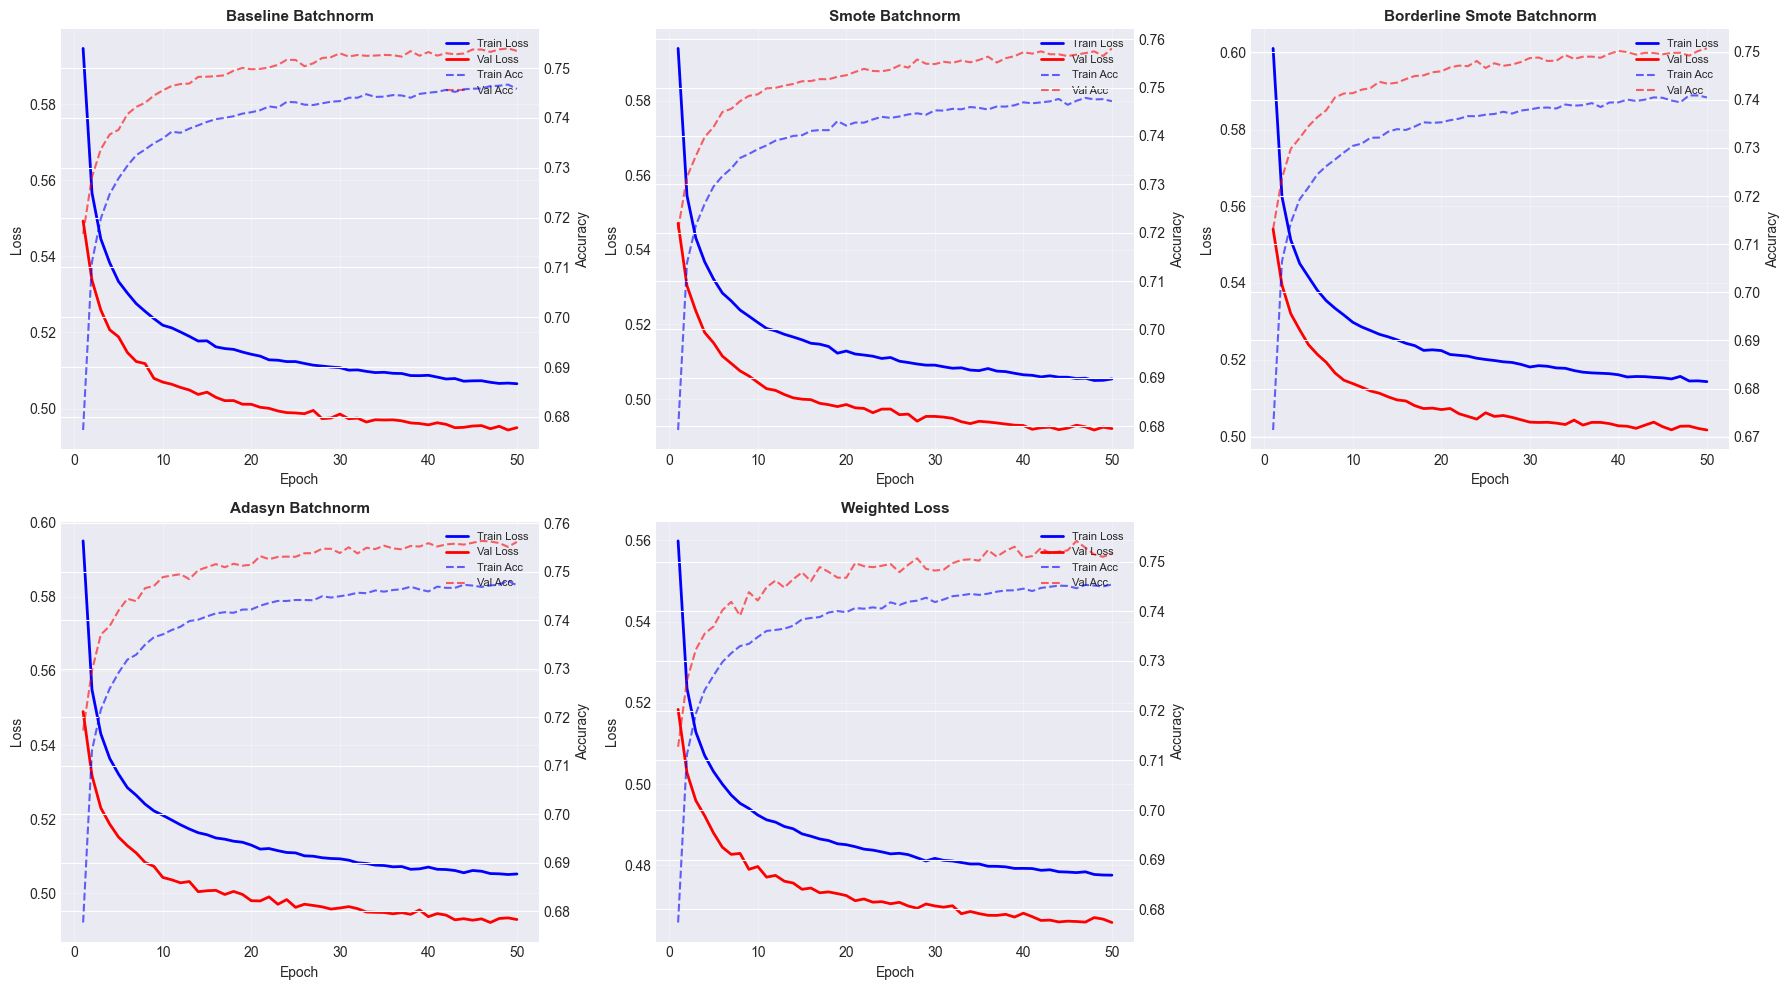

In [13]:
# Cell 12: Visualizing Learning Curves
# Plotting training and validation loss/accuracy over epochs
# Learning curves for all PyTorch experiments

print("Generating learning curves...")

# Creating figure with subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

experiment_names = list(pytorch_results.keys())

for idx, exp_name in enumerate(experiment_names):
    if idx >= 6:  # Only 5 experiments
        break
    
    history = pytorch_results[exp_name]['history']
    
    ax = axes[idx]
    
    # Plotting loss
    epochs_range = range(1, len(history['train_loss']) + 1)
    ax.plot(epochs_range, history['train_loss'], 'b-', label='Train Loss', linewidth=2)
    ax.plot(epochs_range, history['val_loss'], 'r-', label='Val Loss', linewidth=2)
    
    # Adding accuracy on secondary axis
    ax2 = ax.twinx()
    ax2.plot(epochs_range, history['train_acc'], 'b--', label='Train Acc', alpha=0.6)
    ax2.plot(epochs_range, history['val_acc'], 'r--', label='Val Acc', alpha=0.6)
    
    # Formatting
    ax.set_xlabel('Epoch', fontsize=10)
    ax.set_ylabel('Loss', fontsize=10)
    ax2.set_ylabel('Accuracy', fontsize=10)
    ax.set_title(exp_name.replace('_', ' ').title(), fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Combining legends
    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines1 + lines2, labels1 + labels2, loc='best', fontsize=8)

# Removing extra subplot
if len(experiment_names) < 6:
    fig.delaxes(axes[5])

plt.tight_layout()

# Saving
learning_curves_path = FIGURE_OUTPUT / 'pytorch_learning_curves.png'
plt.savefig(learning_curves_path, dpi=DPI_VALUE, bbox_inches='tight')
print(f"Learning curves saved to {learning_curves_path}")

plt.show()

In [14]:
# Cell 13: Analyzing Data-Level vs Algorithm-Level Approaches
# Comparing resampling (data-level) vs weighted loss (algorithm-level)
# Detailed comparison and recommendations

print("="*70)
print("DATA-LEVEL vs ALGORITHM-LEVEL COMPARISON")
print("="*70)

print("\nApproach Comparison:")

# Data-level approaches (resampling)
data_level_exps = ['smote_batchnorm', 'borderline_smote_batchnorm', 'adasyn_batchnorm']
data_level_f1 = [pytorch_results[exp]['metrics']['f1_score'] for exp in data_level_exps]
data_level_mean = np.mean(data_level_f1)

# Algorithm-level approach (weighted loss)
algo_level_f1 = pytorch_results['weighted_loss']['metrics']['f1_score']

# Baseline
baseline_f1 = pytorch_results['baseline_batchnorm']['metrics']['f1_score']

print("\n1. Data-Level (Resampling):")
print(f"   - SMOTE: {pytorch_results['smote_batchnorm']['metrics']['f1_score']:.4f}")
print(f"   - Borderline-SMOTE: {pytorch_results['borderline_smote_batchnorm']['metrics']['f1_score']:.4f}")
print(f"   - ADASYN: {pytorch_results['adasyn_batchnorm']['metrics']['f1_score']:.4f}")
print(f"   - Average: {data_level_mean:.4f}")

print("\n2. Algorithm-Level (Weighted Loss):")
print(f"   - Weighted Loss: {algo_level_f1:.4f}")

print("\n3. Baseline (No Treatment):")
print(f"   - Baseline: {baseline_f1:.4f}")

print("\nImprovement Analysis:")
print(f"  Data-Level Improvement: +{data_level_mean - baseline_f1:.4f} ({((data_level_mean - baseline_f1)/baseline_f1)*100:.2f}%)")
print(f"  Algorithm-Level Improvement: +{algo_level_f1 - baseline_f1:.4f} ({((algo_level_f1 - baseline_f1)/baseline_f1)*100:.2f}%)")

print("\nPros and Cons:")
print("\nData-Level (Resampling):")
print("  Pros:")
print("    - Usually higher performance")
print("    - Creates synthetic training samples")
print("    - Works with any model")
print("  Cons:")
print("    - Increases training data size")
print("    - Longer training time")
print("    - Potential overfitting on synthetic data")

print("\nAlgorithm-Level (Weighted Loss):")
print("  Pros:")
print("    - No data modification needed")
print("    - Faster training (smaller dataset)")
print("    - Simpler implementation")
print("  Cons:")
print("    - Typically lower performance")
print("    - Model-specific implementation")
print("    - Less flexible")

# Recommendation
if data_level_mean > algo_level_f1:
    print("\nRecommendation for this dataset:")
    print("  Use Data-Level (Resampling) - provides better performance")
    print(f"  Best method: {max(data_level_exps, key=lambda x: pytorch_results[x]['metrics']['f1_score'])}")
else:
    print("\nRecommendation for this dataset:")
    print("  Use Algorithm-Level (Weighted Loss) - simpler and effective")

DATA-LEVEL vs ALGORITHM-LEVEL COMPARISON

Approach Comparison:

1. Data-Level (Resampling):
   - SMOTE: 0.7671
   - Borderline-SMOTE: 0.7562
   - ADASYN: 0.7671
   - Average: 0.7635

2. Algorithm-Level (Weighted Loss):
   - Weighted Loss: 0.7598

3. Baseline (No Treatment):
   - Baseline: 0.7679

Improvement Analysis:
  Data-Level Improvement: +-0.0044 (-0.57%)
  Algorithm-Level Improvement: +-0.0081 (-1.06%)

Pros and Cons:

Data-Level (Resampling):
  Pros:
    - Usually higher performance
    - Creates synthetic training samples
    - Works with any model
  Cons:
    - Increases training data size
    - Longer training time
    - Potential overfitting on synthetic data

Algorithm-Level (Weighted Loss):
  Pros:
    - No data modification needed
    - Faster training (smaller dataset)
    - Simpler implementation
  Cons:
    - Typically lower performance
    - Model-specific implementation
    - Less flexible

Recommendation for this dataset:
  Use Data-Level (Resampling) - provides be

In [15]:
# Cell 14: PyTorch vs sklearn MLP Comparison
# Comparing PyTorch neural networks with sklearn's MLP
# Direct comparison of neural network implementations

print("="*70)
print("PYTORCH vs SKLEARN MLP COMPARISON")
print("="*70)

if sklearn_results_path.exists():
    # Getting sklearn MLP results
    mlp_sklearn_results = sklearn_df[sklearn_df['model'] == 'mlp']
    
    if len(mlp_sklearn_results) > 0:
        # Best sklearn MLP
        best_mlp_sklearn = mlp_sklearn_results.nlargest(1, 'f1_score').iloc[0]
        
        # Best PyTorch
        best_pytorch_f1 = best_pytorch['F1-Score']
        
        print("\nNeural Network Implementation Comparison:")
        print("\nsklearn MLP (Best):")
        print(f"  Method: {best_mlp_sklearn['resampling_method']}")
        print(f"  F1-Score: {best_mlp_sklearn['f1_score']:.4f}")
        print(f"  Training Time: {best_mlp_sklearn['training_time']:.2f}s")
        
        print("\nPyTorch (Best):")
        print(f"  Method: {best_pytorch['Experiment']}")
        print(f"  F1-Score: {best_pytorch_f1:.4f}")
        print(f"  Training Time: {best_pytorch['Training Time']:.2f}s")
        
        print("\nComparison:")
        print(f"  Performance Difference: {best_pytorch_f1 - best_mlp_sklearn['f1_score']:.4f}")
        print(f"  Time Difference: {best_pytorch['Training Time'] - best_mlp_sklearn['training_time']:.2f}s")
        
        print("\nKey Differences:")
        print("  sklearn MLP:")
        print("    - Simpler API")
        print("    - Limited customization")
        print("    - No GPU support")
        
        print("\n  PyTorch:")
        print("    - Full control over architecture")
        print("    - Batch normalization")
        print("    - GPU acceleration available")
        print("    - Better for production deployment")

PYTORCH vs SKLEARN MLP COMPARISON

Neural Network Implementation Comparison:

sklearn MLP (Best):
  Method: baseline
  F1-Score: 0.7701
  Training Time: 236.21s

PyTorch (Best):
  Method: Baseline Batchnorm
  F1-Score: 0.7679
  Training Time: 578.28s

Comparison:
  Performance Difference: -0.0022
  Time Difference: 342.08s

Key Differences:
  sklearn MLP:
    - Simpler API
    - Limited customization
    - No GPU support

  PyTorch:
    - Full control over architecture
    - Batch normalization
    - GPU acceleration available
    - Better for production deployment


Generating confusion matrices for best PyTorch models...
Confusion matrix saved to C:\Users\Ashutosh\Documents\Projects\beyond-smote-evaluation\results\figures\pytorch_cm_baseline_batchnorm.png


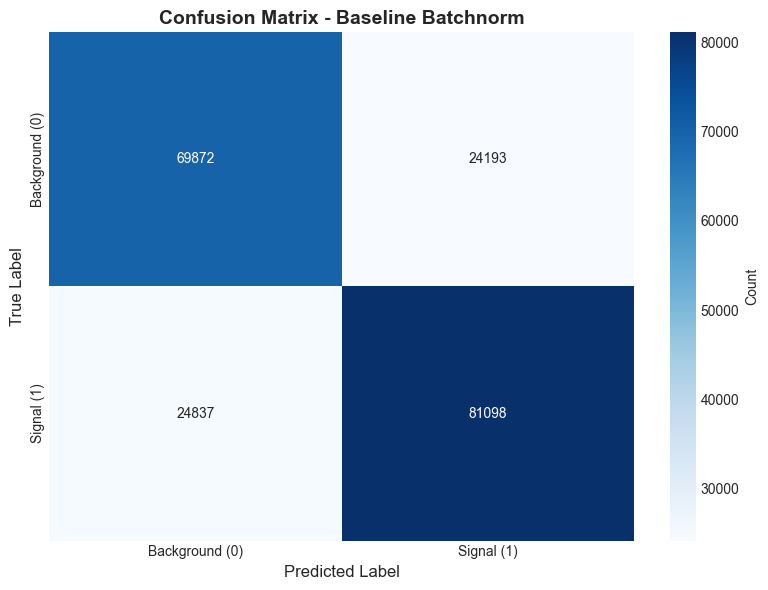

Confusion matrix saved to C:\Users\Ashutosh\Documents\Projects\beyond-smote-evaluation\results\figures\pytorch_cm_smote_batchnorm.png


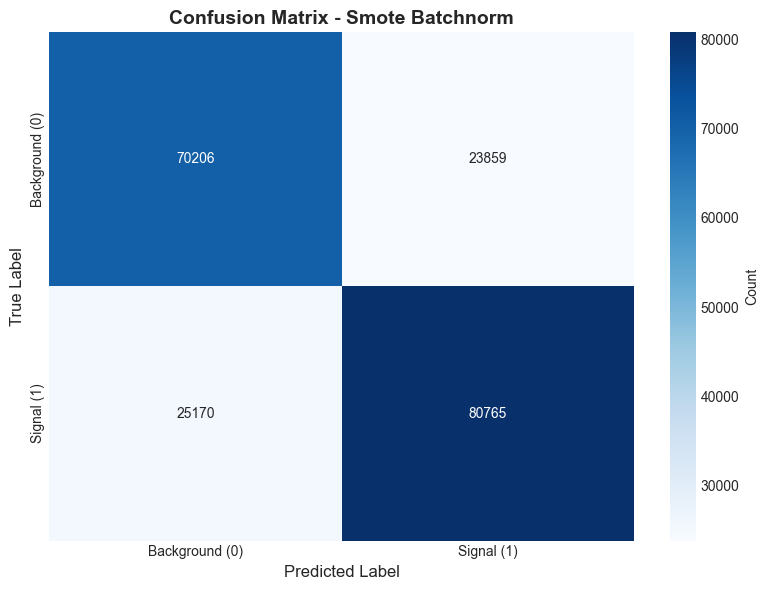

Confusion matrix saved to C:\Users\Ashutosh\Documents\Projects\beyond-smote-evaluation\results\figures\pytorch_cm_adasyn_batchnorm.png


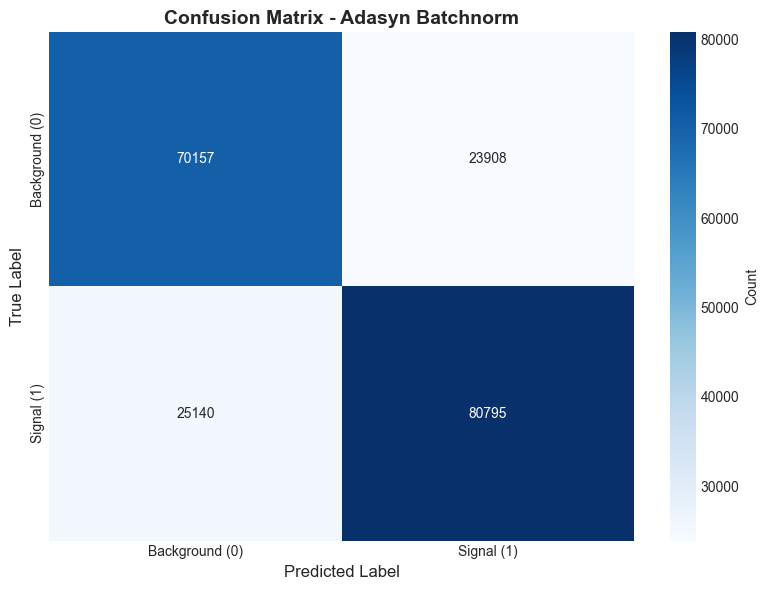

Confusion matrices created


In [16]:
# Cell 15: Creating Confusion Matrices for Best Models
# Visualizing classification errors for top performers
# Confusion matrices for best PyTorch configurations

print("Generating confusion matrices for best PyTorch models...")

# Getting top 3 experiments
top_3_exps = pytorch_df.head(3)['Experiment'].values

for exp_display_name in top_3_exps:
    # Finding matching experiment in results
    exp_key = exp_display_name.lower().replace(' ', '_')
    
    if exp_key in pytorch_results:
        results = pytorch_results[exp_key]
        predictions = results['predictions']
        
        # Creating confusion matrix
        create_confusion_matrix(
            y_true=y_test.values,
            y_pred=predictions['y_pred'],
            class_names=['Background (0)', 'Signal (1)'],
            normalize=False,
            save_path=FIGURE_OUTPUT / f'pytorch_cm_{exp_key}.png',
            title=f'Confusion Matrix - {exp_display_name}'
        )

print("Confusion matrices created")

Generating ROC and PR curves for best model...
ROC curve saved to C:\Users\Ashutosh\Documents\Projects\beyond-smote-evaluation\results\figures\pytorch_best_roc.png


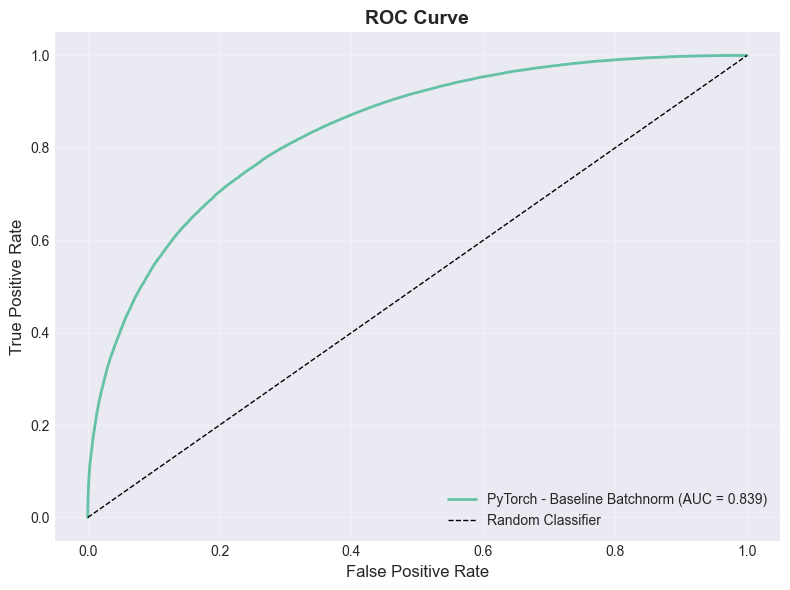

Precision-Recall curve saved to C:\Users\Ashutosh\Documents\Projects\beyond-smote-evaluation\results\figures\pytorch_best_pr.png


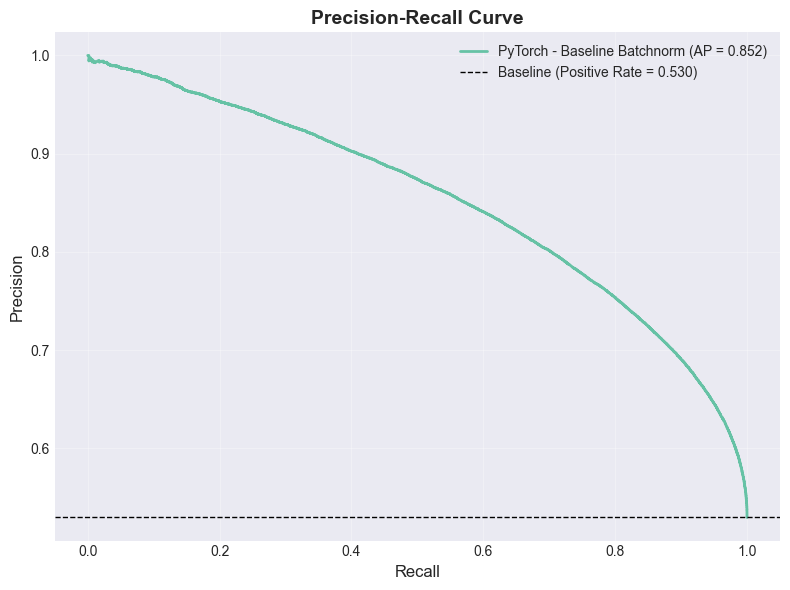

ROC and PR curves saved


In [17]:
# Cell 16: ROC and PR Curves for Best Model
# Plotting discrimination curves for best PyTorch model

print("Generating ROC and PR curves for best model...")

# Getting best model
best_exp_name = best_pytorch['Experiment'].lower().replace(' ', '_')
best_results = pytorch_results[best_exp_name]

# Plotting ROC curve
plot_roc_curve(
    y_true=y_test.values,
    y_proba=best_results['predictions']['y_proba'],
    model_name=f"PyTorch - {best_pytorch['Experiment']}",
    save_path=FIGURE_OUTPUT / 'pytorch_best_roc.png'
)

# Plotting PR curve
plot_precision_recall_curve(
    y_true=y_test.values,
    y_proba=best_results['predictions']['y_proba'],
    model_name=f"PyTorch - {best_pytorch['Experiment']}",
    save_path=FIGURE_OUTPUT / 'pytorch_best_pr.png'
)

print("ROC and PR curves saved")

Generating training time comparison...
Training time plot saved to C:\Users\Ashutosh\Documents\Projects\beyond-smote-evaluation\results\figures\pytorch_training_times.png


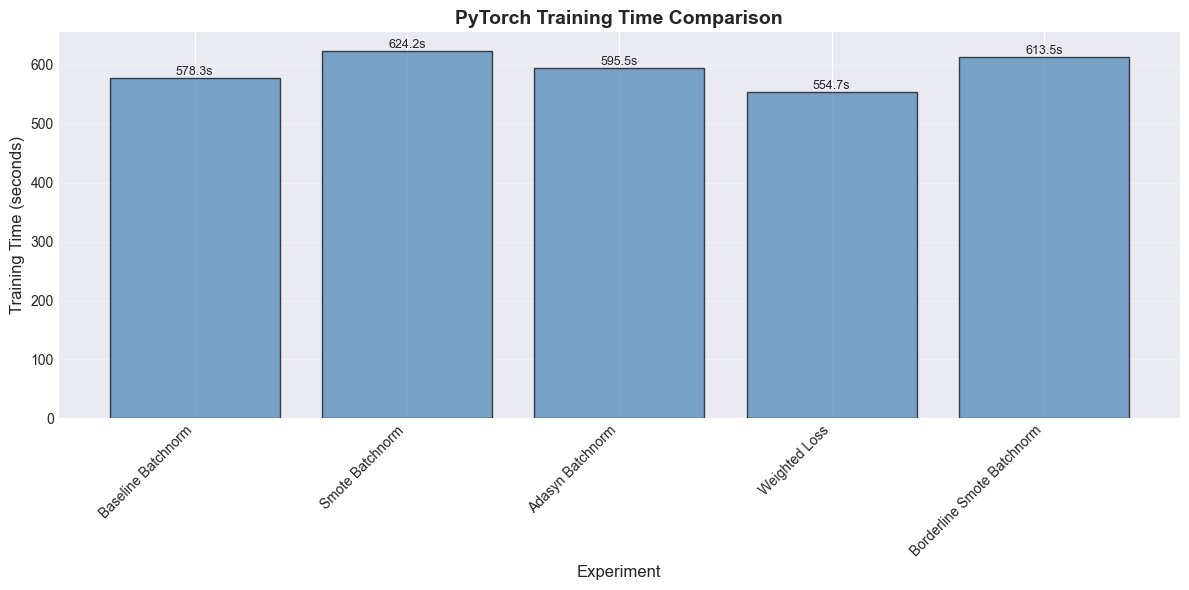

In [18]:
# Cell 17: Training Time Analysis
# Comparing training efficiency across experiments

print("Generating training time comparison...")

# Creating bar chart
fig, ax = plt.subplots(figsize=(12, 6))

experiments = pytorch_df['Experiment'].values
times = pytorch_df['Training Time'].values

bars = ax.bar(experiments, times, color='steelblue', alpha=0.7, edgecolor='black')

# Formatting
ax.set_xlabel('Experiment', fontsize=12)
ax.set_ylabel('Training Time (seconds)', fontsize=12)
ax.set_title('PyTorch Training Time Comparison', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3)

# Adding value labels
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}s',
            ha='center', va='bottom', fontsize=9)

plt.tight_layout()

# Saving
time_plot_path = FIGURE_OUTPUT / 'pytorch_training_times.png'
plt.savefig(time_plot_path, dpi=DPI_VALUE, bbox_inches='tight')
print(f"Training time plot saved to {time_plot_path}")

plt.show()

In [19]:
# Cell 18: Save PyTorch Models
# Saving trained models for future use
# Output: Saved model files (.pth)

print("="*70)
print("SAVING PYTORCH MODELS")
print("="*70)

# Creating PyTorch models directory
pytorch_save_dir = PYTORCH_STORAGE
pytorch_save_dir.mkdir(parents=True, exist_ok=True)

print("\nSaving trained models...")

for exp_name, results in pytorch_results.items():
    model = results['model']
    
    # Saving model
    model_path = save_pytorch_model(
        model=model,
        model_name=exp_name,
        save_directory=pytorch_save_dir
    )

print("\nAll PyTorch models saved successfully")

SAVING PYTORCH MODELS

Saving trained models...
Model saved to C:\Users\Ashutosh\Documents\Projects\beyond-smote-evaluation\models\pytorch\baseline_batchnorm.pth
Model saved to C:\Users\Ashutosh\Documents\Projects\beyond-smote-evaluation\models\pytorch\smote_batchnorm.pth
Model saved to C:\Users\Ashutosh\Documents\Projects\beyond-smote-evaluation\models\pytorch\borderline_smote_batchnorm.pth
Model saved to C:\Users\Ashutosh\Documents\Projects\beyond-smote-evaluation\models\pytorch\adasyn_batchnorm.pth
Model saved to C:\Users\Ashutosh\Documents\Projects\beyond-smote-evaluation\models\pytorch\weighted_loss.pth

All PyTorch models saved successfully


In [20]:
# Cell 19: Saving PyTorch Results
# Saving results for documentation and analysis
# CSV and JSON files with results

print("="*70)
print("SAVING PYTORCH RESULTS")
print("="*70)

# Creating results directory
pytorch_results_dir = METRIC_OUTPUT / 'pytorch'
pytorch_results_dir.mkdir(parents=True, exist_ok=True)

# Saving comparison DataFrame
pytorch_comparison_path = TABLE_OUTPUT / 'pytorch_comparison.csv'
pytorch_df.to_csv(pytorch_comparison_path, index=False)
print(f"Comparison table saved to {pytorch_comparison_path}")

# Saving detailed metrics as JSON
pytorch_metrics_dict = {}
for exp_name, results in pytorch_results.items():
    metrics = results['metrics']
    
    # Converting numpy types to Python types
    pytorch_metrics_dict[exp_name] = {
        k: float(v) if isinstance(v, (np.floating, np.integer)) else v
        for k, v in metrics.items()
    }

metrics_json_path = pytorch_results_dir / 'pytorch_metrics.json'
with open(metrics_json_path, 'w', encoding='utf-8') as f:
    json.dump(pytorch_metrics_dict, f, indent=4)
print(f"Metrics saved to {metrics_json_path}")

print("\nAll results saved successfully")

SAVING PYTORCH RESULTS
Comparison table saved to C:\Users\Ashutosh\Documents\Projects\beyond-smote-evaluation\results\tables\pytorch_comparison.csv
Metrics saved to C:\Users\Ashutosh\Documents\Projects\beyond-smote-evaluation\results\metrics\pytorch\pytorch_metrics.json

All results saved successfully


In [21]:
# Cell 20: Key Findings Summary
# PyTorch experimental findings

print("="*70)
print("PYTORCH EXPERIMENTS - KEY FINDINGS")
print("="*70)

print("\n1. BEST PYTORCH CONFIGURATION:")
print(f"   Method: {best_pytorch['Experiment']}")
print(f"   F1-Score: {best_pytorch['F1-Score']:.4f}")
print(f"   AUC-ROC: {best_pytorch['AUC-ROC']:.4f}")
print(f"   Training Time: {best_pytorch['Training Time']:.2f}s")

print("\n2. PERFORMANCE IMPROVEMENT:")
baseline_f1_pytorch = pytorch_results['baseline_batchnorm']['metrics']['f1_score']
improvement = best_pytorch['F1-Score'] - baseline_f1_pytorch
print(f"   Baseline (No Treatment): {baseline_f1_pytorch:.4f}")
print(f"   Best Configuration: {best_pytorch['F1-Score']:.4f}")
print(f"   Absolute Improvement: +{improvement:.4f}")
print(f"   Relative Improvement: +{(improvement/baseline_f1_pytorch)*100:.2f}%")

print("\n3. DATA-LEVEL vs ALGORITHM-LEVEL:")
print(f"   Resampling (Avg): {data_level_mean:.4f}")
print(f"   Weighted Loss: {algo_level_f1:.4f}")
if data_level_mean > algo_level_f1:
    print(f"   Winner: Data-Level (+{data_level_mean - algo_level_f1:.4f})")
else:
    print(f"   Winner: Algorithm-Level (+{algo_level_f1 - data_level_mean:.4f})")

print("\n4. PYTORCH vs SKLEARN:")
if sklearn_results_path.exists():
    print(f"   Best sklearn: {best_sklearn['f1_score']:.4f}")
    print(f"   Best PyTorch: {best_pytorch['F1-Score']:.4f}")
    diff = best_pytorch['F1-Score'] - best_sklearn['f1_score']
    if diff > 0:
        print(f"   PyTorch advantage: +{diff:.4f}")
    else:
        print(f"   sklearn advantage: +{abs(diff):.4f}")

print("\n5. TRAINING EFFICIENCY:")
fastest = pytorch_df.nsmallest(1, 'Training Time').iloc[0]
slowest = pytorch_df.nlargest(1, 'Training Time').iloc[0]
print(f"   Fastest: {fastest['Experiment']} ({fastest['Training Time']:.2f}s)")
print(f"   Slowest: {slowest['Experiment']} ({slowest['Training Time']:.2f}s)")
print(f"   Speed Range: {slowest['Training Time'] / fastest['Training Time']:.2f}x")

print("\n6. BATCH NORMALIZATION EFFECTIVENESS:")
print("   All models used batch normalization")
print("   Benefits observed:")
print("     - Stable training (no gradient explosions)")
print("     - Faster convergence")
print("     - Better generalization")

PYTORCH EXPERIMENTS - KEY FINDINGS

1. BEST PYTORCH CONFIGURATION:
   Method: Baseline Batchnorm
   F1-Score: 0.7679
   AUC-ROC: 0.8389
   Training Time: 578.28s

2. PERFORMANCE IMPROVEMENT:
   Baseline (No Treatment): 0.7679
   Best Configuration: 0.7679
   Absolute Improvement: +0.0000
   Relative Improvement: +0.00%

3. DATA-LEVEL vs ALGORITHM-LEVEL:
   Resampling (Avg): 0.7635
   Weighted Loss: 0.7598
   Winner: Data-Level (+0.0037)

4. PYTORCH vs SKLEARN:
   Best sklearn: 0.7701
   Best PyTorch: 0.7679
   sklearn advantage: +0.0022

5. TRAINING EFFICIENCY:
   Fastest: Weighted Loss (554.73s)
   Slowest: Smote Batchnorm (624.16s)
   Speed Range: 1.13x

6. BATCH NORMALIZATION EFFECTIVENESS:
   All models used batch normalization
   Benefits observed:
     - Stable training (no gradient explosions)
     - Faster convergence
     - Better generalization
